In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = {}
i = 0

dev = 1
centers = [4, 3, 2]
points_per_cluster = [20, 50, 100, 1000]

for center in centers:
    for n_points in points_per_cluster:
        cluster = [None]*15
        cluster[0] = np.random.normal(0, dev, (n_points,2))
        cluster[1] = np.random.normal(center, dev, (n_points,2))
        cluster[2] = np.random.normal(-center, dev, (n_points,2))
        cluster[3] = np.concatenate((np.random.normal(-center, dev, (n_points,1)),np.random.normal(center, dev, (n_points,1))), axis=1)
        cluster[4] = np.concatenate((np.random.normal(-2*center, dev, (n_points,1)),np.random.normal(0, dev, (n_points,1))), axis=1)
        cluster[5] = np.concatenate((np.random.normal(center, dev, (n_points,1)),np.random.normal(-center, dev, (n_points,1))), axis=1)
        cluster[6] = np.concatenate((np.random.normal(0, dev, (n_points,1)),np.random.normal(2*center, dev, (n_points,1))), axis=1)
        cluster[7] = np.concatenate((np.random.normal(2*center, dev, (n_points,1)),np.random.normal(0, dev, (n_points,1))), axis=1)
        cluster[8] = np.concatenate((np.random.normal(0, dev, (n_points,1)),np.random.normal(-2*center, dev, (n_points,1))), axis=1)
        cluster[9] = np.concatenate((np.random.normal(-1.5*center, dev, (n_points,1)),np.random.normal(-2.5*center, dev, (n_points,1))), axis=1)
        cluster[10] = np.concatenate((np.random.normal(-2.5*center, dev, (n_points,1)),np.random.normal(-1.5*center, dev, (n_points,1))), axis=1)
        cluster[11] = np.concatenate((np.random.normal(1.5*center, dev, (n_points,1)),np.random.normal(2.5*center, dev, (n_points,1))), axis=1)
        cluster[12] = np.concatenate((np.random.normal(2.5*center, dev, (n_points,1)),np.random.normal(1.5*center, dev, (n_points,1))), axis=1)
        cluster[13] = np.concatenate((np.random.normal(-3*center, dev, (n_points,1)),np.random.normal(-3*center, dev, (n_points,1))), axis=1)
        cluster[14] = np.concatenate((np.random.normal(3*center, dev, (n_points,1)),np.random.normal(3*center, dev, (n_points,1))), axis=1)
             
        data[i] = {'center': center, 'n_points': n_points, 'cluster': cluster}
        i = i + 1
        
df = pd.DataFrame.from_dict(data)
df = df.T
df.to_pickle('data_gauss.pkl')

In [11]:
import torch

def silhouette(X, y):
    if not torch.is_tensor(X):
        X = torch.from_numpy(X).float()
    if not torch.is_tensor(y):
        y = torch.from_numpy(y).float()
    distances = torch.cdist(X, X, p=2)
    weighted_distances = torch.matmul(distances, y)
    sum_p = torch.sum(y, dim = 0)
    sum_p_mat = torch.empty(y.shape[0], y.shape[1])
    for i in range(y.shape[0]):
        sum_p_mat[i] = sum_p - y[i]
    alphas = torch.div(weighted_distances, sum_p)
    betas = torch.empty(alphas.shape[0], alphas.shape[1])
    for i in range(alphas.shape[0]):
        for j in range(alphas.shape[1]):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    max_ab = torch.max(alphas, betas)
    s = betas - alphas
    s = torch.div(s, max_ab)
    s = s*y
    s = torch.sum(s, dim=1)
    s = torch.mean(s)
    return s

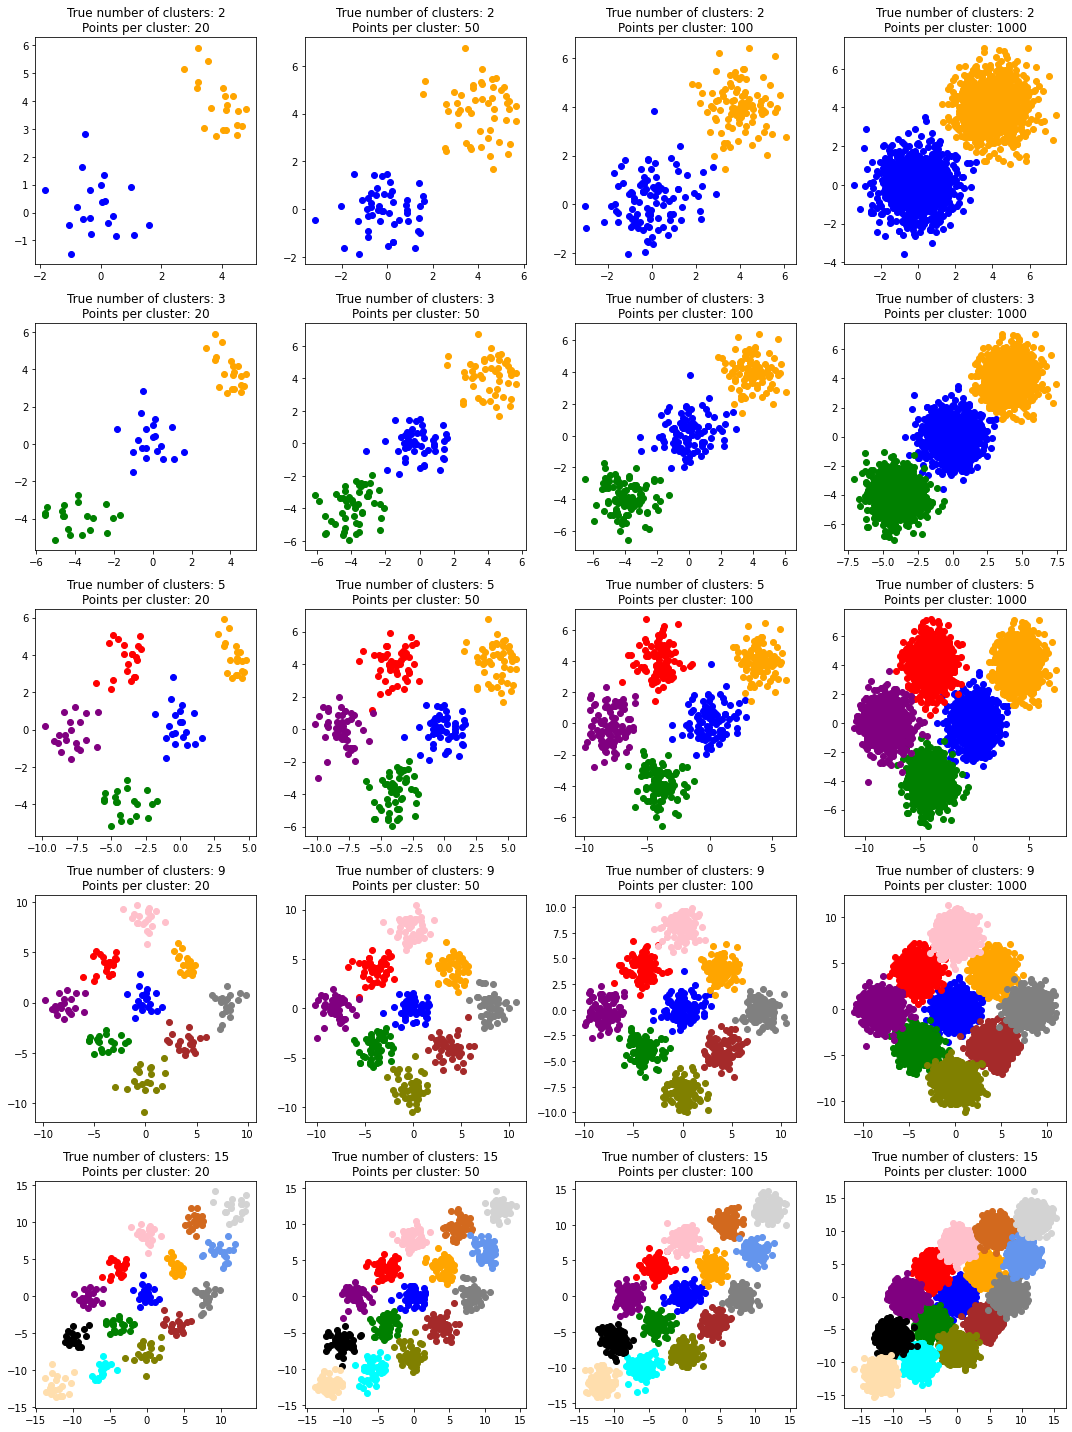

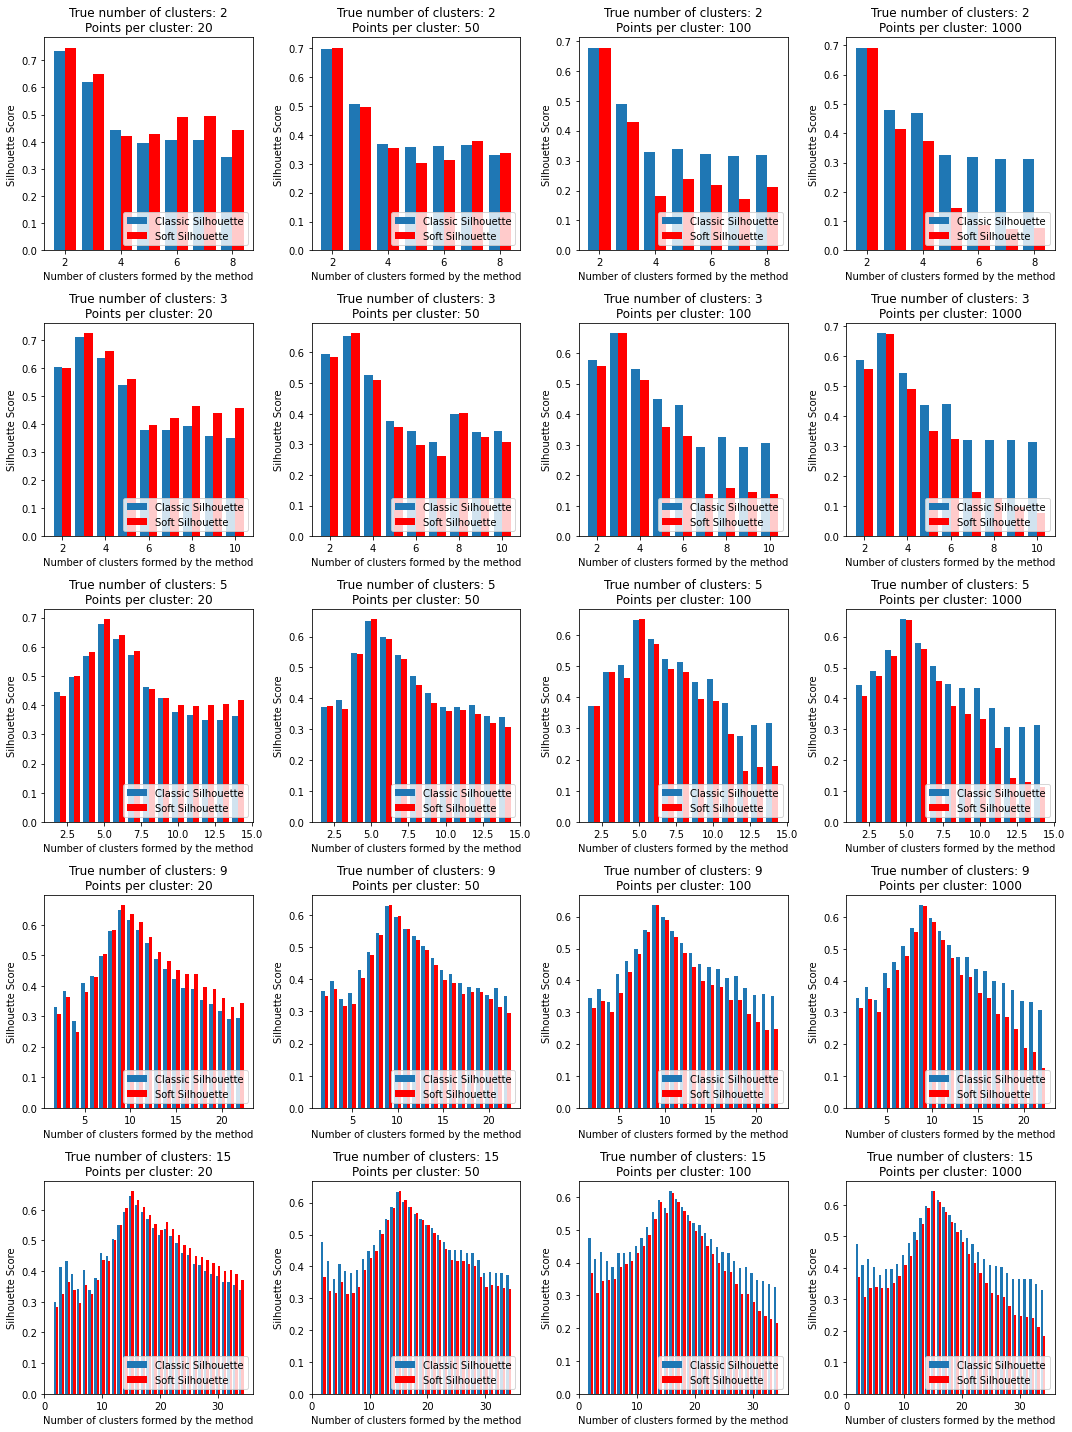

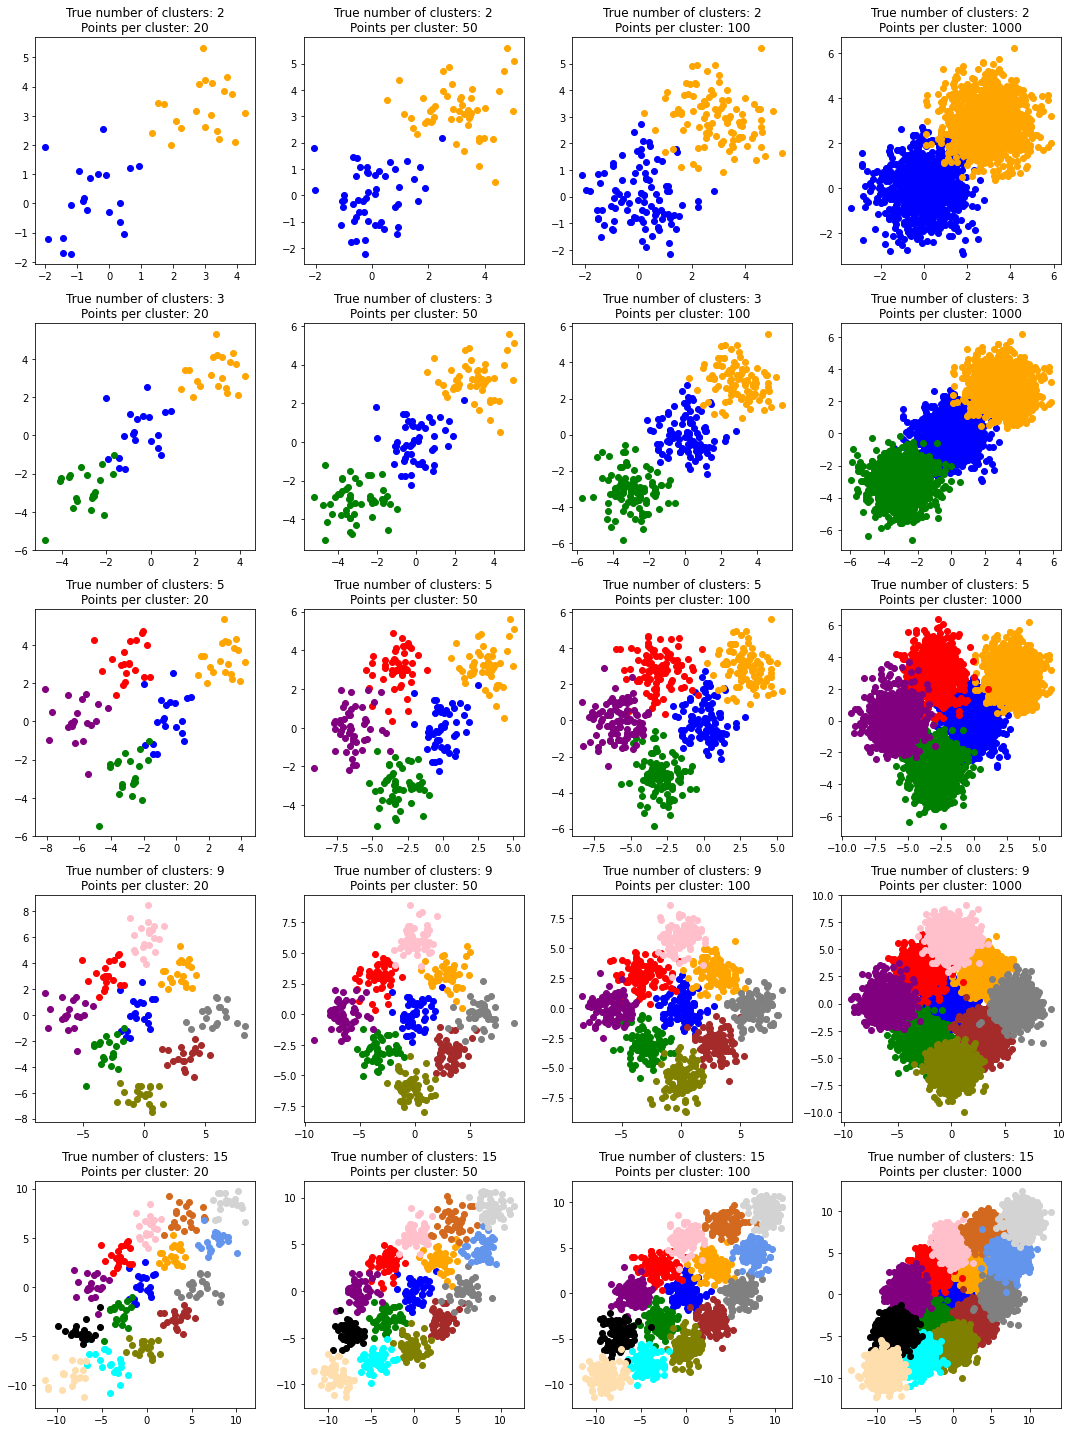

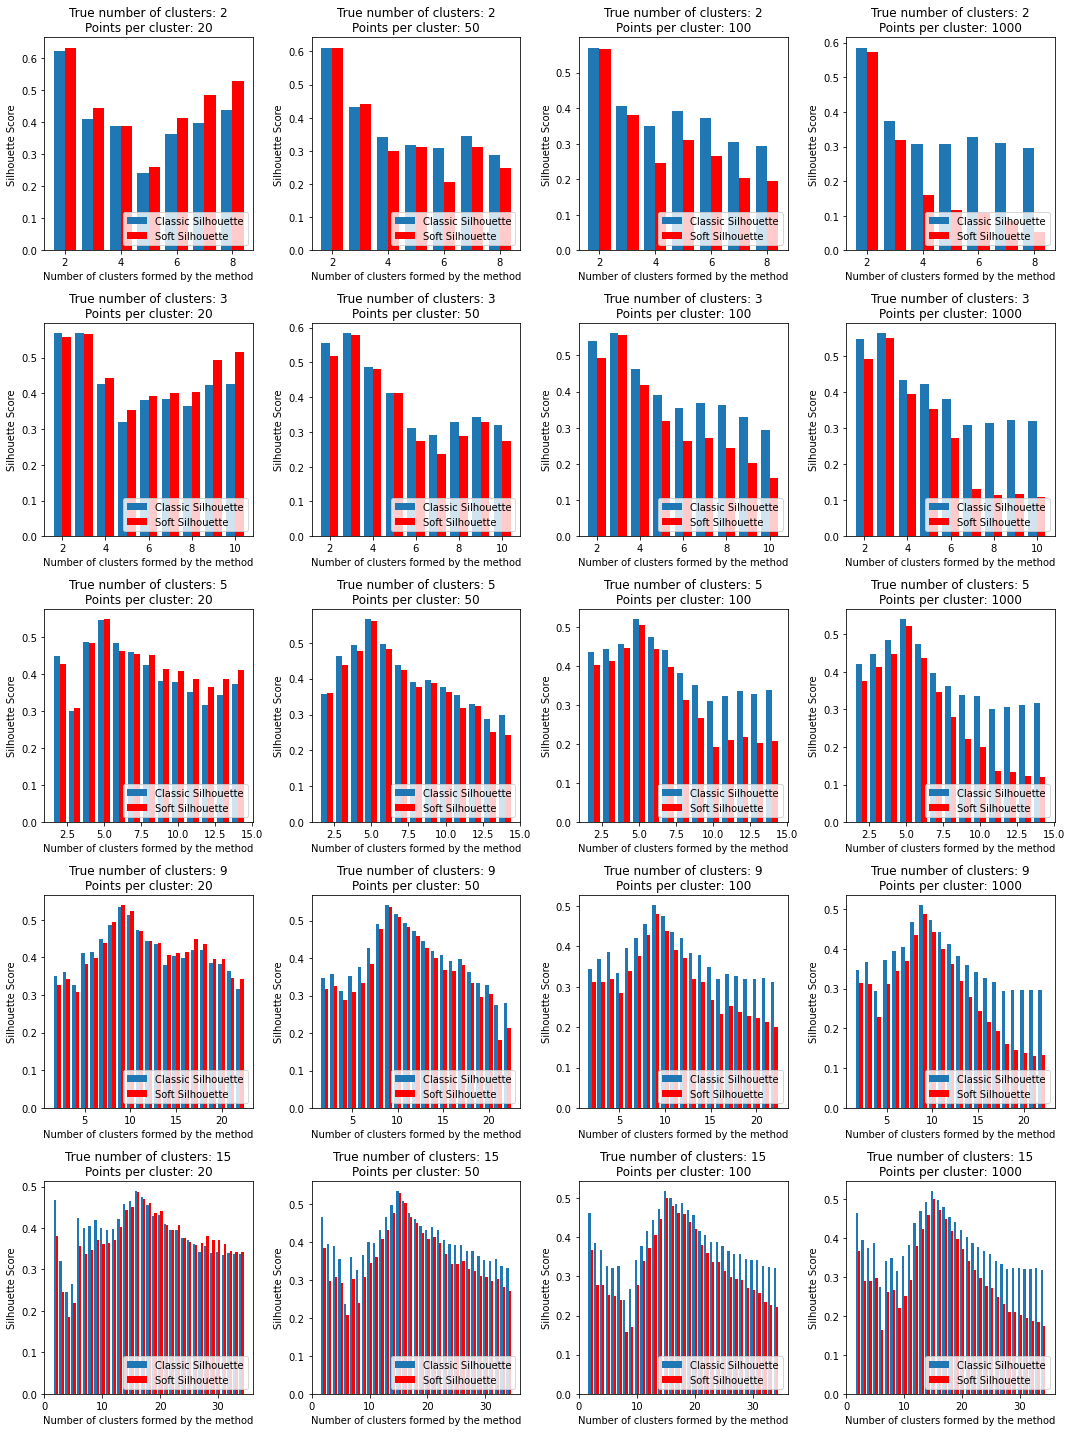

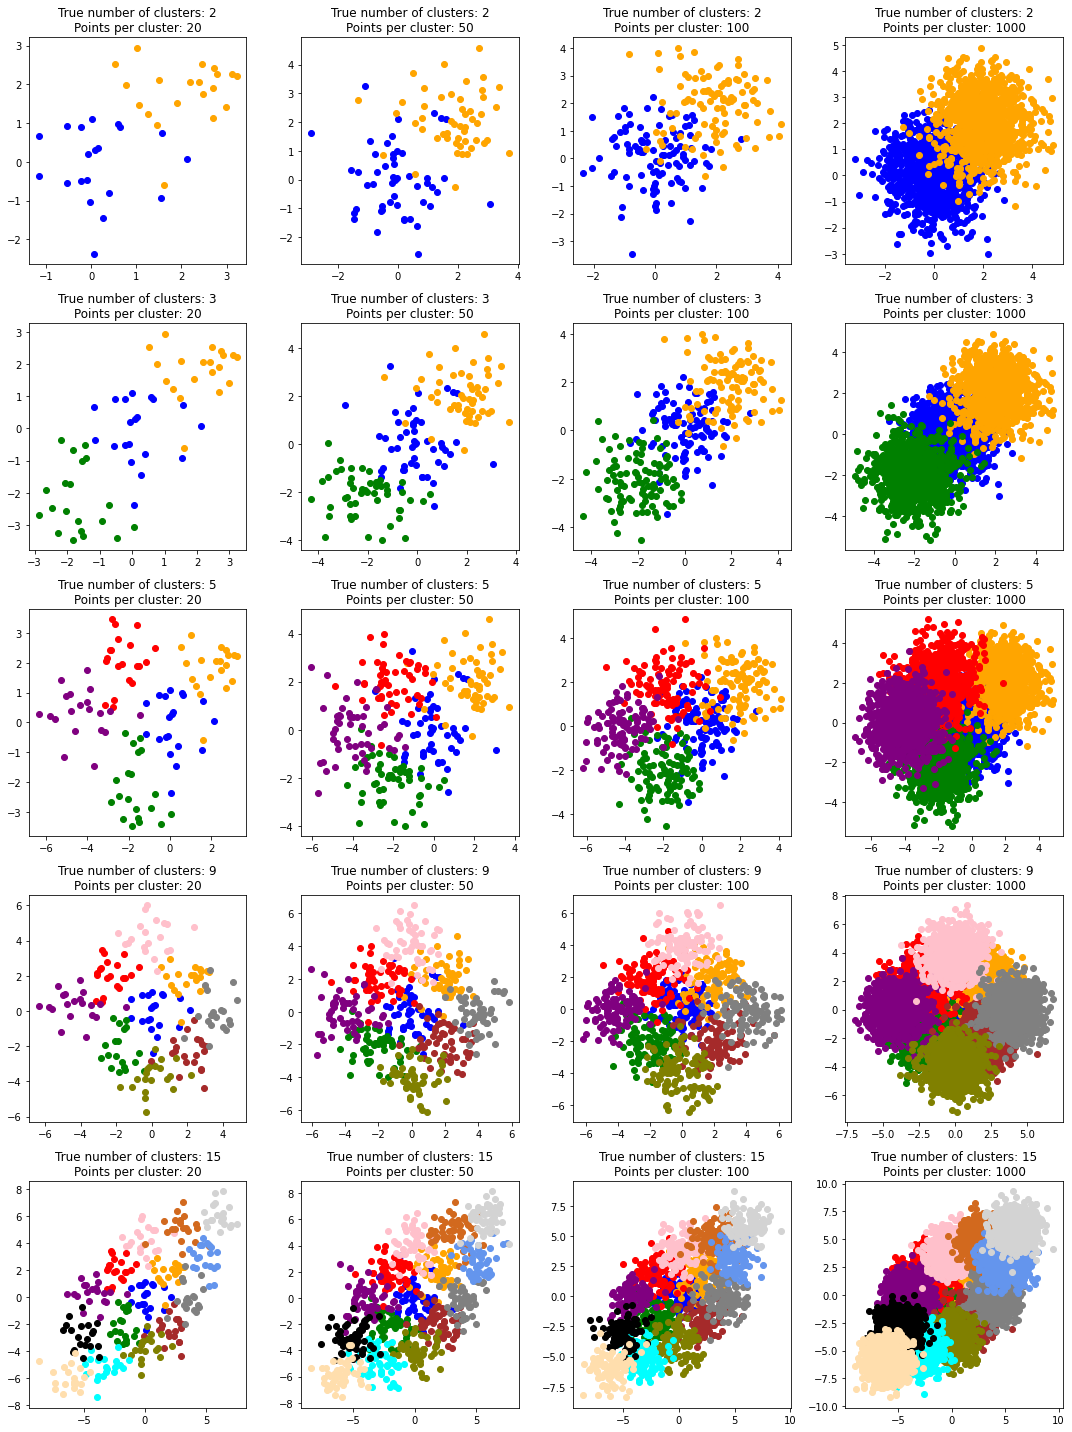

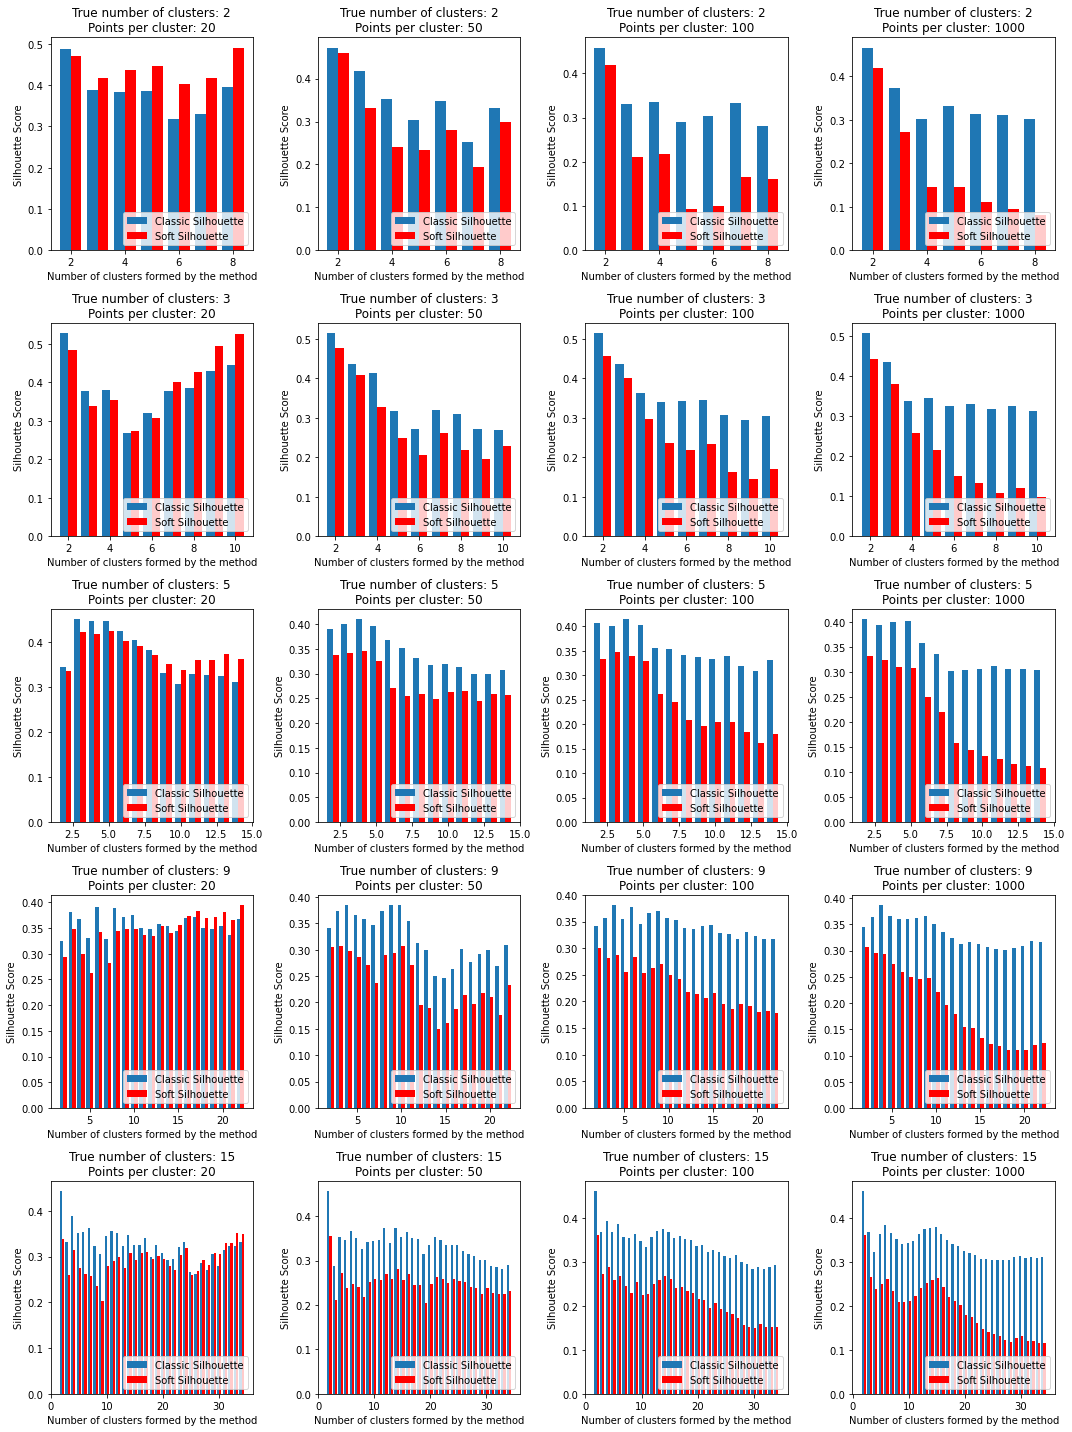

In [3]:
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn import metrics

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'chocolate', 'cornflowerblue', 'navajowhite', 'lightgrey']
n_clusters = [2, 3, 5, 9, 15]

for center in centers:
    ddf = df[df['center']==center]
    fig_cluster, axs_cluster = plt.subplots(5, 4,figsize=(15,20))
    fig_scores, axs_scores = plt.subplots(5, 4,figsize=(15,20))

    for idx, row in ddf.iterrows():
        for c in n_clusters:
            n = row['n_points']
            x_axs = n_clusters.index(c)
            y_axs = points_per_cluster.index(n)
            X = row['cluster'][0]
            axs_cluster[x_axs, y_axs].scatter(row['cluster'][0][:,0], row['cluster'][0][:,1], c = colors[0])
            for i in range(1,c):
                X = np.concatenate((X,row['cluster'][i]))
                axs_cluster[x_axs, y_axs].scatter(row['cluster'][i][:,0], row['cluster'][i][:,1], c = colors[i])
            axs_cluster[x_axs, y_axs].set_title(f'True number of clusters: {c}\nPoints per cluster: {n}')

            X = shuffle(X, random_state=0)

            soft_score = []
            score = []
            n_alg_clusters = []
            for i in range(2,2*c+5):
                n_alg_clusters.append(i)
                gm = GaussianMixture(n_components=i, random_state=0).fit(X)
                probabilities = gm.predict_proba(X)
                probabilities = np.around(probabilities, decimals=6)
                maxprob_index = np.argmax(probabilities, axis=-1)


                score.append(metrics.silhouette_score(X, maxprob_index, metric='euclidean'))
                soft_score.append(silhouette(X, probabilities))

            _X = np.arange(len(n_alg_clusters))
            axs_scores[x_axs, y_axs].bar(_X+2-0.2,score, width=0.4, label='Classic Silhouette')
            axs_scores[x_axs, y_axs].bar(_X+2+0.2,soft_score, width=0.4, label='Soft Silhouette', color='red')
            axs_scores[x_axs, y_axs].set_title(f'True number of clusters: {c}\nPoints per cluster: {n}')
            axs_scores[x_axs, y_axs].legend(loc="lower right")
            axs_scores[x_axs, y_axs].set_xlabel('Number of clusters formed by the method')
            axs_scores[x_axs, y_axs].set_ylabel('Silhouette Score')

    fig_scores.tight_layout()
    fig_cluster.tight_layout()
    plt.show()

In [12]:
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

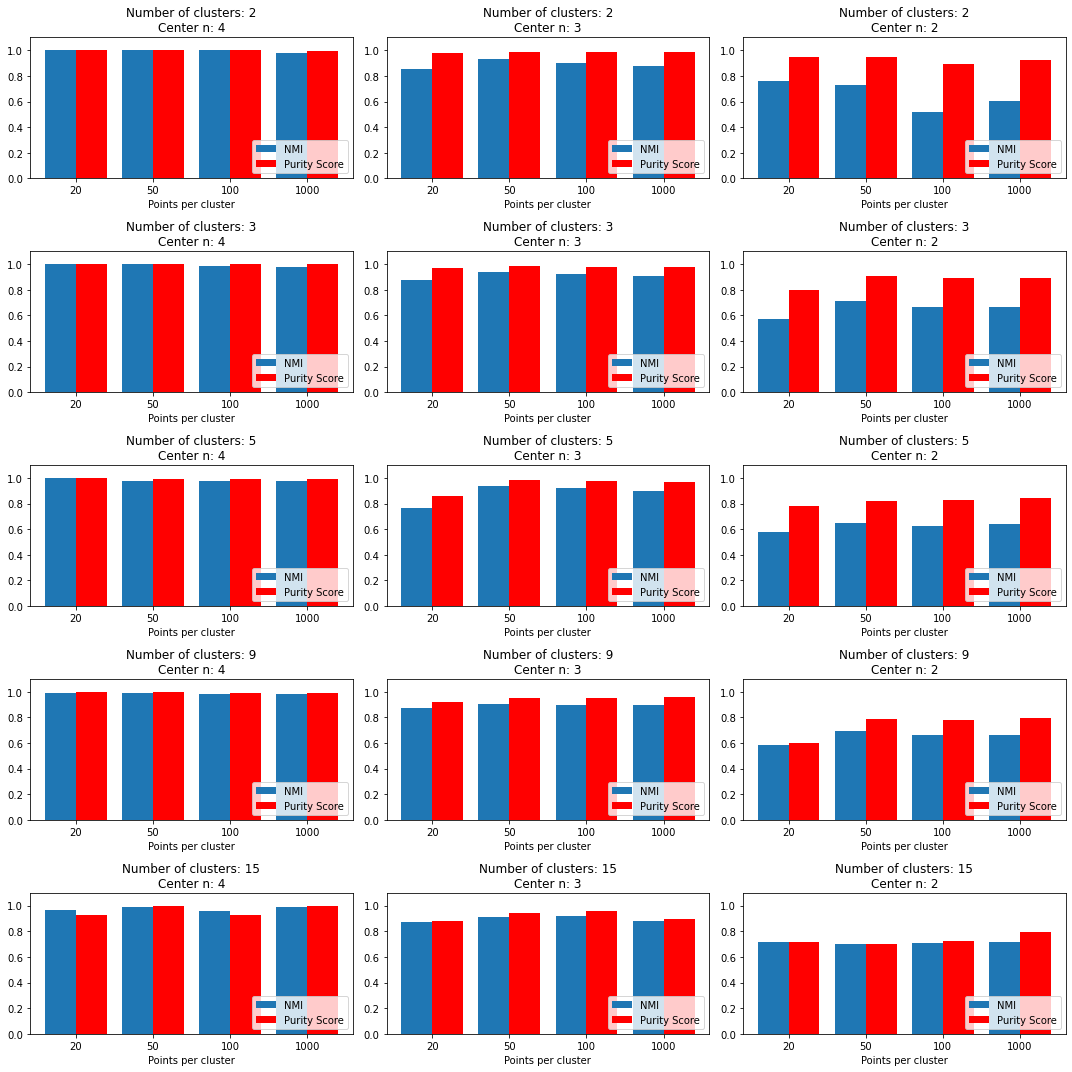

In [16]:
n_clusters = [2, 3, 5, 9, 15]

fig, axs = plt.subplots(5, 3,figsize=(15,15))
for center in centers:
    ddf = df[df['center']==center]
    for c in n_clusters:
        purity_scores = []
        nmi_scores = []
        
        x_axs = n_clusters.index(c)
        y_axs = centers.index(center)
        for idx, row in ddf.iterrows():
            n = row['n_points']
            
            X = row['cluster'][0]
            
            
            y_true = np.array([0]*n)
            for i in range(1,c):
                X = np.concatenate((X,row['cluster'][i]))
                y_true = np.concatenate((y_true, np.array([i]*n)))

            X, y_true = shuffle(X, y_true, random_state=0)
            gm = GaussianMixture(n_components=c, random_state=0).fit(X)
            probabilities = gm.predict_proba(X)
            probabilities = np.around(probabilities, decimals=6)
            maxprob_index = np.argmax(probabilities, axis=-1)
            purity_scores.append(purity_score(y_true, maxprob_index))
            nmi_scores.append(normalized_mutual_info_score(y_true, maxprob_index))
            
        _X = np.arange(len(points_per_cluster))
        axs[x_axs, y_axs].bar(_X-0.2, nmi_scores, width=0.4, label='NMI')
        axs[x_axs, y_axs].bar(_X+0.2, purity_scores, width=0.4, label='Purity Score', color='red')
        axs[x_axs, y_axs].set_xticks(_X)
        axs[x_axs, y_axs].set_xticklabels(points_per_cluster, minor=False)
        axs[x_axs, y_axs].set_ylim(top=1.1)
        axs[x_axs, y_axs].legend(loc="lower right")
        axs[x_axs, y_axs].set_title(f'Number of clusters: {c}\nCenter n: {center}')
        axs[x_axs, y_axs].set_xlabel('Points per cluster')
        
fig.tight_layout()